In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path

## Relevant functions from utils

In [13]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

### Compare MCMC logacceptratio and number of samples to HMC

In [3]:
# Compare mcmc and hmc logacceptratio and num generated samples
# Acceptratio values are stored for each experiement in a file like this: "results_dir/logacceptratio_{i}.csv" where indices are 0-132
# Samples are stored for each experiement in file like this: "results_dir/samples_{i}_{experiment_name}_{interval}_{polarity}.csv" where indices are 0-132
results_dir_mcmc = f'../../../results/v23.0/'

# Load results from MCMC run
mcmc_acc_ratio = []
mcmc_num_samples = []
num_results = 400_000

for i in range(0, 132):
    experiment_name = df.iloc[i]['experiment_name']
    interval = df.iloc[i]['interval']
    polarity = df.iloc[i]['polarity']
    samples = pd.read_csv(f'{results_dir_mcmc}samples_{i}_{experiment_name}_{interval}_{polarity}.csv')
    mcmc_num_samples.append(samples.shape[0])

    mcmc_acc_ratio.append(samples.shape[0]/num_results)

mcmc_acc_ratio = np.array(mcmc_acc_ratio)
mcmc_num_samples = np.array(mcmc_num_samples)
mcmc_avg_acc_ratio = mcmc_acc_ratio.mean()
mcmc_avg_num_samples = mcmc_num_samples.mean()
print(f"MCMC acceptance ratio average: {mcmc_avg_acc_ratio}")
print(f"MCMC average number of samples: {mcmc_avg_num_samples}")

MCMC acceptance ratio average: 0.3270968371212121
MCMC average number of samples: 130838.73484848485


In [6]:
# Load results from HMC run
results_dir_hmc = f'../../../results/v22.0/'
hmc_acc_ratio = []
hmc_num_samples = []
num_results = 110_000

for i in range(0, 132):
    experiment_name = df.iloc[i]['experiment_name']
    interval = df.iloc[i]['interval']
    polarity = df.iloc[i]['polarity']
    samples = pd.read_csv(f'{results_dir_hmc}samples_{i}_{experiment_name}_{interval}_{polarity}.csv')
    hmc_num_samples.append(samples.shape[0])

    hmc_acc_ratio.append(samples.shape[0]/num_results)

hmc_acc_ratio = np.array(hmc_acc_ratio)
hmc_num_samples = np.array(hmc_num_samples)
hmc_avg_acc_ratio = hmc_acc_ratio.mean()
hmc_avg_num_samples = hmc_num_samples.mean()
print(f"HMC acceptance ratio average: {hmc_avg_acc_ratio}")
print(f"HMC average number of samples: {hmc_avg_num_samples}")

HMC acceptance ratio average: 0.9749813360881543
HMC average number of samples: 107247.94696969698


### Create ACF 2 plot figure

In [7]:
# find index in df for experiment_name='AMS02_H-PRL2021' and interval='20130221-20130319'
idx = df[(df['experiment_name'] == 'AMS02_H-PRL2021') & (df['interval'] == '20130221-20130319')].index[0]
print(f"Index for experiment_name='AMS02_H-PRL2021' and interval='20130221-20130319': {idx}")

Index for experiment_name='AMS02_H-PRL2021' and interval='20130221-20130319': 24


In [14]:
# pick a specific experiment to compare, let's use 24
# create a two plot figure that stacks the ACF of mcmc v23.0 and ACF of hmc v22.0
experiment_index = 24
experiment_name = df.iloc[experiment_index]['experiment_name']
interval = df.iloc[experiment_index]['interval']
polarity = df.iloc[experiment_index]['polarity']
hmc_sample = np.loadtxt(f'{results_dir_hmc}samples_{experiment_index}_{experiment_name}_{interval}_{polarity}.csv', delimiter=',')
mcmc_sample = np.loadtxt(f'{results_dir_mcmc}samples_{experiment_index}_{experiment_name}_{interval}_{polarity}.csv', delimiter=',')

print(f"Experiment: {experiment_name}, interval: {interval}, polarity: {polarity}")
print(f"Number of HMC samples: {hmc_sample.shape} out of 110_000, so acc ratio is {hmc_sample.shape[0]/110_000}")
print(f"Number of MCMC samples: {mcmc_sample.shape} out of 400_000, so acc ratio is {mcmc_sample.shape[0]/400_000}")

Experiment: AMS02_H-PRL2021, interval: 20130221-20130319, polarity: neg
Number of HMC samples: (108837, 5) out of 110_000, so acc ratio is 0.9894272727272727
Number of MCMC samples: (51506, 5) out of 400_000, so acc ratio is 0.128765


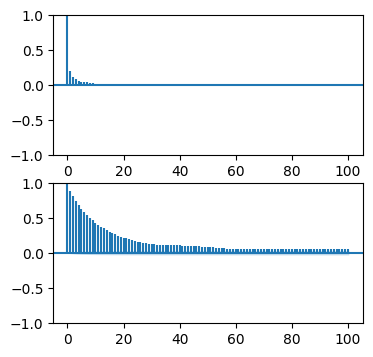

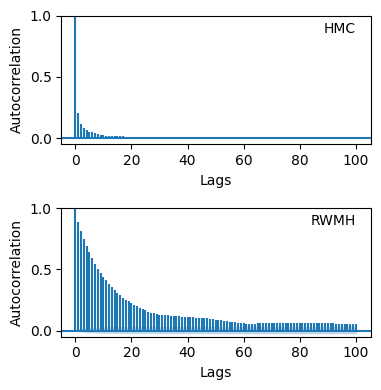

In [15]:
# Plot the autocorrelation
fig, axs = plt.subplots(2, 1, figsize=(4, 4))

# reduce mcmc_sample by 100 to estimate thinning needed to match performance
# mcmc_sample = mcmc_sample[::100]

# NOTE: randomly chose cpa, could be any parameter
plot_acf(hmc_sample[:, 0], lags=100, ax=axs[0], title="", markersize=0)
plot_acf(mcmc_sample[:, 0], lags=100, ax=axs[1], title="", markersize=0)

min_y = -0.05
max_y = 1

# Have the two plots share axes
fig, axs = plt.subplots(2, 1, figsize=(4, 4))

# reduce mcmc_sample by 100 to estimate thinning needed to match performance
# mcmc_sample = mcmc_sample[::100]

# NOTE: randomly chose cpa, could be any parameter
plot_acf(hmc_sample[:, 0], lags=100, ax=axs[0], title="", markersize=0)
plot_acf(mcmc_sample[:, 0], lags=100, ax=axs[1], title="", markersize=0)

min_y = -0.05
max_y = 1

# Have the two plots share axes
axs[0].set_ylim(min_y, max_y)
axs[1].set_ylim(min_y, max_y)

# Add titles to the top right corner of each plot
axs[0].text(0.95, 0.95, "HMC", transform=axs[0].transAxes, ha='right', va='top')
axs[1].text(0.95, 0.95, "RWMH", transform=axs[1].transAxes, ha='right', va='top')

axs[0].set_ylabel('Autocorrelation')
axs[1].set_ylabel('Autocorrelation')
axs[0].set_xlabel('Lags')
axs[1].set_xlabel('Lags')

plt.tight_layout()
plt.savefig(f'../../../results/autocorrelation_{experiment_name}_{interval}_{polarity}.pdf')
plt.show()

### Create trace and ACF plots

In [ ]:
# Select experiment parameters
df = index_mcmc_runs()  # List of all ~200 experiments.

# Model specification
version = 'v21.0' # 'v1.0'
reduce_by = 1 # Reduce the number of MCMC samples by this factor. 9 for v2.0/v5.0, 1 for v1.0/v3.0/v4.0, 30 for v6.0

# Setup  output directory.
results_dir = f'../../../results/{version}/'
figs_dir = f'{results_dir}figs/'
Path(figs_dir).mkdir(parents=True, exist_ok=True)

print(df.head())
print(df.shape)

In [ ]:
# Load samples, logprobs, and predictions to each respective index in the dataframe
for i in [21]: #len(df)):
    experiment_name = df["experiment_name"].iloc[i]
    interval = df.interval.iloc[i]
    polarity = df.polarity.iloc[i]

    filename = f'{results_dir}samples_{i}_{experiment_name}_{interval}_{polarity}.csv'
    print(f"Filename: {filename}")

    samples = np.loadtxt(filename, delimiter=',')
    # logprobs = np.loadtxt(f'{results_dir}logprobs_{i}_{experiment_name}_{interval}_{polarity}.csv', delimiter=',')
    # predictions = np.loadtxt(f'{results_dir}predictions_{i}_{experiment_name}_{interval}_{polarity}.csv', delimiter=',')
    
    # Examine only a few samples. Take 1 out of every 9 samples.
    samples = samples[::reduce_by, :]
    samples_small = samples[::50, :]
    print(f"Samples shape: {samples.shape}. Small samples shape: {samples_small.shape}")

    # Make a 5 by 2 plot of the trace and acf of the samples
    fig, axes = plt.subplots(5, 2, figsize=(22, 20))
    axes[0, 0].plot(samples_small[:, 0])
    axes[1, 0].plot(samples_small[:, 1])
    axes[2, 0].plot(samples_small[:, 2])
    axes[3, 0].plot(samples_small[:, 3])
    axes[4, 0].plot(samples_small[:, 4])

    lags = 500
    plot_acf(samples[:, 0], lags=lags, ax=axes[0, 1], title="", markersize=0)
    plot_acf(samples[:, 1], lags=lags, ax=axes[1, 1], title="", markersize=0)
    plot_acf(samples[:, 2], lags=lags, ax=axes[2, 1], title="", markersize=0)
    plot_acf(samples[:, 3], lags=lags, ax=axes[3, 1], title="", markersize=0)
    plot_acf(samples[:, 4], lags=lags, ax=axes[4, 1], title="", markersize=0)

    # Get min and maxc from acf plots
    min_y = -0.05
    max_y = 0.5

    axes[0, 1].set_ylim(min_y, max_y)
    axes[1, 1].set_ylim(min_y, max_y)
    axes[2, 1].set_ylim(min_y, max_y)
    axes[3, 1].set_ylim(min_y, max_y)
    axes[4, 1].set_ylim(min_y, max_y)

    # Make a title for each column and each row
    for ax, col in zip(axes[0], ['Trace', 'ACF']):
        ax.set_title(col)
    for ax, col in zip(axes[4], ['Iteration', 'Lag']):
        ax.set_xlabel(col, size='large')
    for ax, row in zip(axes[:,0], ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']):
        ax.set_ylabel(row, size='large')

    # Set super title that is the filename
    fig.suptitle(f'samples_{i}_{experiment_name}_{interval}_{polarity}', fontsize=16)

    # Remove whitespace below title and between columns
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])   

    plt.savefig(f'{figs_dir}{i}_{experiment_name}_{interval}_{polarity}.png')
    plt.show()

: 